## IMPORTS

In [32]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
import tensorflow as tf
import json
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

# DATA AND MODEL LOAD

## INTRODUCTION AND DEFINATIONS

1. Instruction fine-tuning (IFT)
   -------------------------------------
Instruction fine-tuning trains a (usually) generative language model to follow natural-language instructions. Training data are instruction → response pairs (optionally with an input). The model learns to map an instruction (and optionally context) to a free-form text answer.      
When to use it:   
When you want a generative model that follows user instructions — e.g., summarization, question answering, code generation, reformulation, “explain like I’m 5”, multi-step tasks.\
How it works (core idea)   \
a. Data format: each example is a triple (instruction, input, output) (input may be empty). At training time you build a single text prompt that concatenates instruction and input with delimiting tokens/strings, then the model is trained to generate the output tokens conditioned on that prompt.   
b. Loss: token-level cross-entropy (teacher forcing) across the target output tokens. Optionally you can mask loss on the prompt tokens so only output tokens contribute to the loss.    
c. Model type: causal (decoder-only) LMs like GPT or decoder of encoder-decoder models. The typical setup uses the same autoregressive training as language modeling, but with supervised targets equal to the expected response.    
d. Objective: improve alignment with human instructions — produce helpful, correct, safe outputs.\
{   
  "instruction": "Summarize the paragraph in one sentence.",    
  "input": "The company reported 40% growth in Q2 driven by higher sales across APAC. Costs increased slightly but margins remained healthy.",    
  "output": "The company grew 40% in Q2 with strong APAC sales and maintained healthy margins despite slightly higher costs."   
}


2. Classification fine-tuning (CFT)
   -------------------------------------
What it is (short):   
Fine-tuning a model to predict a discrete class label for an input string. Supervised training on (text, label) pairs. Output is a class (or probabilities over classes).   
When to use it:   
Sentiment analysis, spam detection, topic classification, intent classification, toxic content detection, NER (with adjustments), multi-label tagging.

text,label   
"I loved the movie, great acting",positive   
"Terrible experience, will not come back",negative   



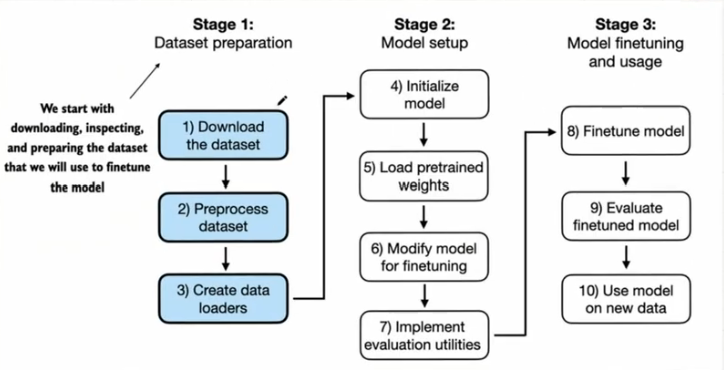

 ## DATA DOWNLOAD- data preprocess - balance  AND SAVE

In [32]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [33]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df.head(3)

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [34]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [35]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)

## important
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})


print(balanced_df["Label"].value_counts())

Label
0    747
1    747
Name: count, dtype: int64


In [36]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder


In [37]:
train_df.to_csv(r"sms_spam_collection/train.csv", index=None)
validation_df.to_csv(r"sms_spam_collection/validation.csv", index=None)
test_df.to_csv(r"sms_spam_collection/test.csv", index=None)

 ## DATASET CLASS

In [33]:



# The SpamDataset class loads data from the CSV files we created earlier, tokenizes the text
# using the GPT-2 tokenizer from tiktoken and allows us to pad or truncate the sequences to
# a uniform length determined by either the longest sequence or a predefined maximum

# OUTPUT FROM THIOS WILL BE SERVED TO DATALOADER

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None: # IF THE MAX LENGTH IS NOT SPECIFIED IF CALL THE _longest_encoded_length TO GET THE MAX LENGTH
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence LENGTH
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [34]:
train_dataset = SpamDataset(
    csv_file="sms_spam_collection/train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)
#model can handle sequences of up to 1,024 tokens, given its context length limit
#IF dataset includes longer texts, you can pass max_length=1024 when creating the training dataset in the
# preceding code to ensure that the data does not exceed the model's supported input (context) length.


val_dataset = SpamDataset(
    csv_file="sms_spam_collection/validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="sms_spam_collection/test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

120


In [35]:
next(iter(train_dataset))

(tensor([   35,  2507,   703,   466,   345,   588,   262,  6940,  2344,    13,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]),
 tensor(0))

## DATALOADER CLASS

In [36]:


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [37]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [38]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

## every batch will take 8 rows of data

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


## loading GPT2 MODEL

In [39]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [40]:
def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


tf_ckpt_path = tf.train.latest_checkpoint("gpt2/124M/")
settings = json.load(open("gpt2/124M/hparams.json"))
params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

In [59]:
from MODEL_llm import GPTModel
from load_weights_from_GPT import load_weights_into_gpt
checkpoint = torch.load("model_and_optimizer.pth", map_location=torch.device('cpu'))
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)

In [16]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## BASIC CHECK OF MODEL UNDERSTANDING

In [44]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens): # MAXIMUM ITERATION OF THE PREDICTIONS
        
 
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:] # SETTING THE CONTEXT WINDOW
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) 
            #PASSING THE INPUTS THROUGH THE MODEL
            #DIMENSION= BATCH, NTOKENS , VOCAB SIZE PREDICTION
            
        # EXTRACT only on the last time step , THE LAST TIMESTEP HAS SEEN ALL THE WORDS AND CAPTURED THE WHOLE SENSE
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities TO GET PROBABLITY OF BEST TOKEN FROM  - VOCAB SIZE PREDICTION
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [62]:

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())
    
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor
    
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you forward.

The first step is to understand the importance of your work


# CLASSIFICATION HEAD AND SELECTIVE LAYER FINETUNING


### We will not train those layers which understand the language and semantics , instead we will only train model to perform the specific task of classification , 

      
#### we will train - 
1. Final Linear output layer
2. scale and shift in the final layer normalization
3. 1/12 transformer block in the end


REPLACE -   
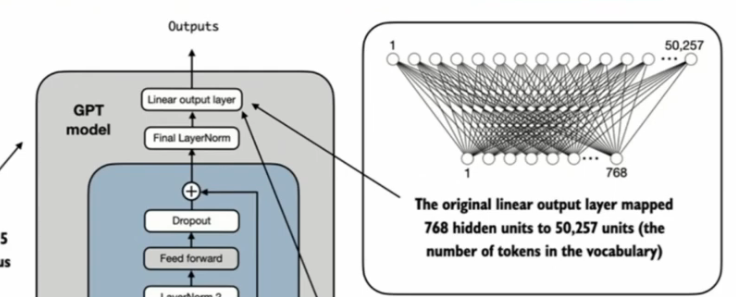   

   
WITH   
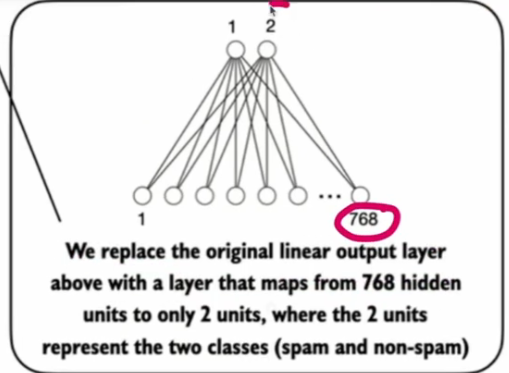

In [64]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

## Model Modification

<div class="alert alert-block alert-warning">

We could technically use a single output node since we are dealing with a binary
classification task. 

However, this would require modifying the loss function.

Therefore, we choose a
more general approach where the number of output nodes matches the number of
classes. 

For example, for a 3-class problem, such as classifying news articles as
"Technology", "Sports", or "Politics", we would use three output nodes, and so forth.
</div>

<div class="alert alert-block alert-success">

1. To get the model ready for classification-finetuning, we first freeze the model weights and bias, making all layers non-trainable

2. Then, replace the output layer (model.out_head), which originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary): -- in this case  2

3. now new model.out_head output layer has its requires_grad attribute set to True by default, which means that it's the only layer in the model that will be updated during training. and the last transformer block loc[-1]
</div>

In [72]:
#1 
for param in model.parameters():
    param.requires_grad = False

In [73]:
#2
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [74]:
#3
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

## Defining loss to use backpropagation

### Test the new modification

In [78]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [80]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)
# each word has a prediction as usaul

Outputs:
 tensor([[[1.8811, 0.9426],
         [6.6425, 4.3872],
         [5.1639, 2.6002],
         [3.9158, 1.7230]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [81]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[3.9158, 1.7230]])


In [84]:
#Using the softmax function here is optional because the largest outputs directly correspond to the highest probability scores. 
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 0


### Loss calculator

In [85]:
# This function calculates the model’s classification accuracy on a given dataloader.
# It loops over batches, runs the model in evaluation mode without gradients, takes the logits of the last token,
# converts them into predicted class labels,
# compares them with the true labels, 
# counts how many predictions are correct, and finally returns the accuracy (correct / total).

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 53.75%
Validation accuracy: 55.00%
Test accuracy: 51.25%


As we can see, the prediction accuracies are near a random prediction, which would be
50% in this case.    
To improve the prediction accuracies, we need to finetune the model.

In [87]:
def calc_loss_batch(input_batch, target_batch, model, device):
    
    # This function computes the cross-entropy loss for one batch.
    # It moves the inputs and labels to the device, runs the model,
    # takes only the logits of the last token, and 
    # calculates how far the model’s predicted class distribution is from the true label using cross-entropy loss.
        
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [89]:
# This function computes the average loss over a dataloader.
# It loops through batches (optionally limited by num_batches), calculates the loss for each batch using calc_loss_batch,
# sums the losses, and returns the mean loss across all processed batches.


# calc_accuracy_loader
# ------
# Measures how many predictions are correct.
# Compares the model’s predicted class with the true label.
#correct_predictions += (predicted_labels == target_batch).sum().item()
# Returns a number between 0 and 1 (accuracy).

# What it answers:
#correct_predictions += (predicted_labels == target_batch).sum().item()
# “Out of all examples, how many did the model classify correctly?”

# calc_loss_loader
# ------
# Measures how wrong the model’s predictions are using cross-entropy.
# Adds the loss for each batch and returns the average loss.
# Lower loss = better model, but it’s not a percentage.
#loss = calc_loss_batch(input_batch, target_batch, model, device)==torch.nn.functional.cross_entropy(logits, target_batch)
# What it answers:
# “On average, how far are the model’s predictions from the correct label?”


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
        
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [90]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.408
Validation loss: 2.296
Test loss: 2.525


## FINETUNING on Supervised data

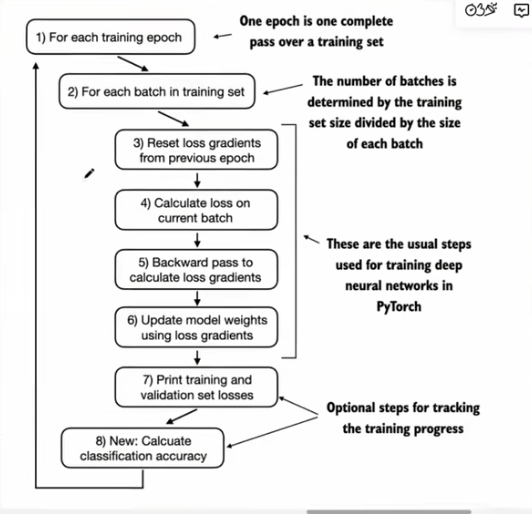

train_classifier_simple 

This function trains a classifier for multiple epochs.
For each batch, it:
1. Computes the loss with calc_loss_batch
2. Backpropagates (loss.backward())
3. Updates model weights (optimizer.step())
4. Optionally evaluates the model during training using evaluate_model

After every epoch, calculates train accuracy and validation accuracy
It returns:
1. train losses over time
2. validation losses over time
3. train accuracies per epoch
4. validation accuracies per epoch
5. total examples seen

In [94]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optionally evaluates the model during training using evaluate_model
            ## we have 130 batches of data, and eval freq=50 then after every 50 batches we do the eval
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [95]:
# evaluate_model temporarily switches the model to evaluation mode, 
# computes the average training loss and average validation loss using only a limited number of batches (eval_iter), 
# and then switches the model back to training mode. It returns the two loss values.

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [96]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.392, Val loss 2.184
Ep 1 (Step 000050): Train loss 0.652, Val loss 0.654
Ep 1 (Step 000100): Train loss 0.510, Val loss 0.572
Training accuracy: 87.50% | Validation accuracy: 90.00%
Ep 2 (Step 000150): Train loss 0.343, Val loss 0.314
Ep 2 (Step 000200): Train loss 0.077, Val loss 0.116
Ep 2 (Step 000250): Train loss 0.037, Val loss 0.208
Training accuracy: 92.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.143, Val loss 0.179
Ep 3 (Step 000350): Train loss 0.065, Val loss 0.107
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 4 (Step 000400): Train loss 0.031, Val loss 0.128
Ep 4 (Step 000450): Train loss 0.048, Val loss 0.094
Ep 4 (Step 000500): Train loss 0.173, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss 0.140, Val loss 0.100
Ep 5 (Step 000600): Train loss 0.050, Val loss 0.116
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 13.45 

In [98]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

NameError: name 'plot_values' is not defined

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

## USING THE LLM AS A SPAM CLASSIFIER

In [100]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [110]:
text_1 = (
    "well done buddy, you won the contest, you will recieve the award of $10000 "
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [111]:
torch.save({
    "classification_model_state_dict": model.state_dict(),
    "classification_model_optimizer_state_dict": optimizer.state_dict(),
    },
    "classification_model_model_and_optimizer.pth"
)